In [1]:
import utils_data as ut
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertForMaskedLM, BertTokenizer
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=512)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')

In [2]:
classes = {'POLYMER': 1,
           'ORGANIC': 2,
           'MONOMER': 3,
           'PROP_NAME': 4,
           'INORGANIC': 5,
           'MATERIAL_AMOUNT': 6,
           'POLYMER_FAMILY': 7,
           'PROP_VALUE': 8,
           'O': 0}
max_length = 512
batch_size = 5
torch.manual_seed(1421)
class NERBERTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = modelBERT.base_model
        self.linear = nn.Linear(768, len(classes) + 1)
        
    def forward(self, token, attention_mask):
        encoder_output= self.bert(token, attention_mask)
        linear_output = self.linear(encoder_output.last_hidden_state)
        return linear_output

In [3]:
model = NERBERTModel()

In [4]:
# num_data = 200
data_list = ut.read_data('train.json', max_length)#[:num_data]

In [5]:
token_tensors_all_list = [ut.list2token(tokenizerBERT, d['words'], max_length) for d in data_list]
data = torch.cat(token_tensors_all_list, dim=0)
data_batches = ut.to_batches(data, batch_size)
target_tensors_all_list = [ut.cat2digit(classes, d['ner'], max_length)[0] for d in data_list]
target = torch.stack(target_tensors_all_list, dim=0)
target_batches = ut.to_batches(target, batch_size)
att_mask_all_list = [ut.cat2digit(classes, d['ner'], max_length)[1] for d in data_list]
att_mask = torch.stack(att_mask_all_list, dim=0)
att_mask_batches = ut.to_batches(att_mask, batch_size)

In [6]:
c = list(zip(data_batches, target_batches, att_mask_batches))
random.shuffle(c)
data_batches, target_batches, att_mask_batches = zip(*c)

In [7]:
# counts = torch.unique(target, return_counts=True)[1][:-1]
# weights = sum(counts) / counts
# weights_n = weights / torch.norm(weights)
# weights_n = torch.cat((weights_n, torch.tensor([0])))
weights = torch.tensor([0.01, 0.5, 1, 1, 0.8, 1, 1, 1, 0.5, 0.0])
weights_n = weights / torch.norm(weights)
criterion = nn.CrossEntropyLoss(weight=weights_n)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)


In [8]:
epochs = 5
train_losses = []
train_accuracy = []
for epoch in range(epochs):
    train_loss_batch = []
    train_accuracy_batch = []
    for b, X in enumerate(data_batches):
        y_pred = model(X, attention_mask=att_mask_batches[b])
        y_pred = torch.swapaxes(y_pred, 1, 2)
        y = target_batches[b]
        
        loss = criterion(y_pred, y)
        acc, predicted_classes, true_classes = ut.accuracy(0, len(classes), y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_batch.append(loss.item())
        train_accuracy_batch.append(acc)
        if b % 100 == 0:
            print(f'epoch: {epoch:2}  batch: {b:3}  loss: {loss.item():.6f}   accuracy: {acc:.4f}')
            print(predicted_classes)
    
    train_loss_batch_mean = sum(train_loss_batch) / len(train_loss_batch)
    train_accuracy_batch_mean = sum(train_accuracy_batch) / len(train_accuracy_batch)    
    print(f'mean training loss at epoch {epoch}: {train_loss_batch_mean}')
    print(f'mean training accuracy at epoch {epoch}: {train_accuracy_batch_mean}')
    train_losses.append(train_loss_batch_mean)
    train_accuracy.append(train_accuracy_batch_mean)

epoch:  0  batch:   0  loss: 2.364066   accuracy: 0.2091
tensor([1, 1, 7, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 7, 3, 1, 1, 5, 3, 1, 5, 1, 1, 1,
        9, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 7, 7, 3, 1,
        1, 1, 1, 0, 2, 1, 3, 1, 3, 1, 3, 1, 3, 2, 2, 1, 6, 1, 3, 1, 1, 3, 1, 1,
        1, 3, 1, 1, 5, 5, 5, 5, 1, 5, 1, 9, 1, 5, 1, 9, 9, 5, 9, 5, 9, 5, 9, 1,
        5, 1, 2, 5, 1, 3, 1, 3, 1, 3, 5, 9, 5, 5])
epoch:  0  batch: 100  loss: 0.909645   accuracy: 0.7947
tensor([7, 4, 4, 4, 4, 4, 4, 4, 4, 8, 7, 1, 1, 1, 1, 1, 1, 7, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 0, 1, 4,
        4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 3, 3, 4, 4, 4, 4, 4, 8,
        4, 4, 4, 4, 4, 8, 8, 7, 4, 4, 4, 8, 8, 8, 0, 0, 4, 4, 4, 8, 8, 5, 1, 1,
        1, 5, 4, 4, 8, 8, 8, 1, 4, 8, 8, 8, 5, 6, 6, 6, 5, 1, 1, 5, 1, 5, 6, 6,
        6, 6, 1, 5, 1, 7, 7, 3, 1, 3, 1, 4, 4, 8, 1, 7, 4, 4, 6, 6, 6, 6, 4, 4,
        8, 4, 4, 8, 6, 0, 6])
mean 

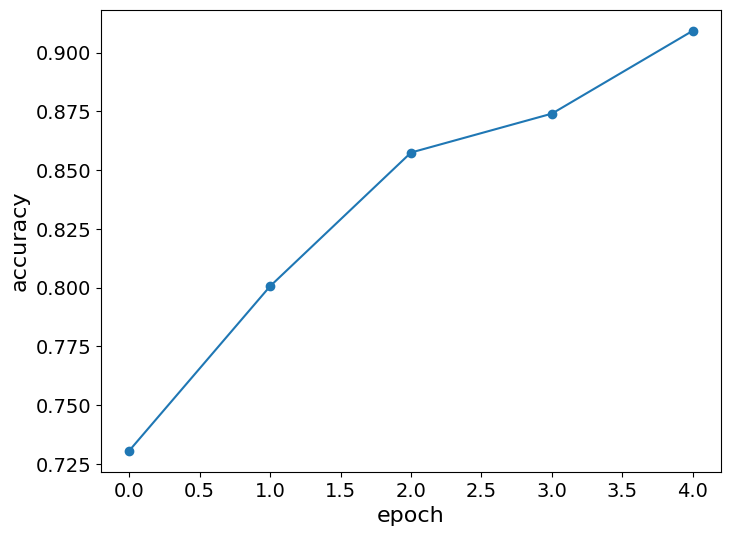

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_accuracy, 'o-')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

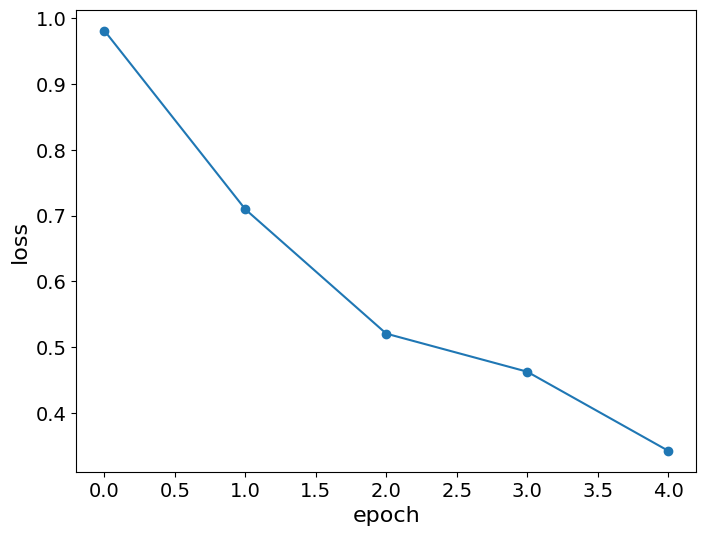

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, 'o-')
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Test 

In [23]:
def preprocess(json_file, tokenizer, num, batch_size, max_length, test=False):
    if num == 0:
        data_list = ut.read_data(json_file, max_length)
    else:
        data_list = ut.read_data(json_file, max_length)[:num]
    token_tensors_all_list = [ut.list2token(tokenizer, d['words'], max_length) for d in data_list]
    data = torch.cat(token_tensors_all_list, dim=0)
    if test:
        batch_size = data.shape[0]
    data_batches = ut.to_batches(data, batch_size)
    target_tensors_all_list = [ut.cat2digit(classes, d['ner'], max_length)[0] for d in data_list]
    target = torch.stack(target_tensors_all_list, dim=0)
    target_batches = ut.to_batches(target, batch_size)
    att_mask_all_list = [ut.cat2digit(classes, d['ner'], max_length)[1] for d in data_list]
    att_mask = torch.stack(att_mask_all_list, dim=0)
    att_mask_batches = ut.to_batches(att_mask, batch_size)
    if test:
        return data_batches[0], target_batches[0], att_mask_batches[0]
    else:
        c = list(zip(data_batches, target_batches, att_mask_batches))
        random.shuffle(c)
        data_batches, target_batches, att_mask_batches = zip(*c)
        return data_batches, target_batches, att_mask_batches

In [24]:
data_test, target_test, att_mask_test = preprocess('test.json', tokenizerBERT, 
                                                   num=0, batch_size=0, max_length=max_length, test=True)

In [42]:
with torch.no_grad():
    y_pred_test = model(data_test, attention_mask=att_mask_test)
y_pred_test = torch.swapaxes(y_pred_test, 1, 2)
acc_test, pred_classes_test, true_classes_test = ut.accuracy(0, len(classes), y_pred_test, target_test)
print(f'{acc_test.item():.3f}')
    

0.783


In [43]:
torch.save(model.state_dict(), f"saved_model_first.pt")